# **Поиск оптимального значения n для n-грамм, для наиболее точного определения языка введенного текста**

### Импортирование необходимых библиотек

In [1]:
import json
import re
import os
import math
import matplotlib.pyplot as plt
import numpy as np

### Глобальные переменные

In [2]:
global path
root_path = os.getcwd() # папка где лежит прога

### Функция разбиения корпусов на строки текста (из txt файла получаем одну строку текста)

In [3]:
def load_corpora_sentences(path):
    with open(path, 'r', encoding = 'utf-8') as f:
        lines = f.readlines()
        sentences = [line.split('\t',1)[1].strip() for line in lines]
    return ' '.join(sentences)

### Функция очистки полученной строки от лишних символов (ковычки, скобки, числа и прочее)

In [4]:
def clean(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) # очистка от чисел
    text = re.sub(r'[«»“”"()\[\]{}<>\\|/@#$%^&*+=~`№;:!?.,]', '', text) # очистка от символов
    text = re.sub(r'\s+', ' ', text) #лишние пробелы
    text = text.replace(" ", "_")
    return text.strip()

### Функция разбиения готовый строки на N-граммы

In [5]:
def generate_ngrams(text, n):
    return [text[i:i+n] for i in range(len(text) - n + 1)]

### Функция подсчета частоты, с которой встречается N-грамма

In [6]:
def ngrams_frequency_calculate(ngrams):
    freq = {}
    for item in ngrams:
        freq[item] = freq.get(item, 0) + 1
    return freq

### Нормализация полученных данных

In [7]:
def normalize_freq(freq):
    total = sum(freq.values())
    if total > 0: return {ngram: count / total for ngram, count in freq.items()}
    else: return {}

### Функция создания и записи данных о частотах N-грамм для каждого языка

In [8]:
def create_ngram_freq(text, language, type):
    # куда сохраняются файлы нормированных словарей
    save_location = os.path.join(root_path, type, language) # соедение папок в общий путь
    os.makedirs(save_location, exist_ok=True) # создает нужные папки
    
    for n in range(2, 7):
        ngrams = generate_ngrams(text, n) # создали список нграм
        freq = ngrams_frequency_calculate(ngrams) # словарь встречающихся нграм
        freq_normalized = normalize_freq(freq) # отнормировали
        file_name = f'freq_{language}_n{n}.json'
        file_path = os.path.join(save_location, file_name) # D://wtf/arabic/ + file.json
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(freq_normalized, f, ensure_ascii=False)

### На данном этапе вся основная логика прописана, осталось получить данные из корпусов

In [ ]:
language_paths = {}
corpora_path = os.path.join(root_path, 'corpora')
raw_data_file_names = os.listdir(corpora_path) # получил список файлов в папке

for lang_file in raw_data_file_names:
    name, extension = lang_file.split('.') # получили имя и расширения файла
    language_paths[name] = os.path.join(corpora_path, f'{name}.{extension}') # записали в словарь ключ = язык, значение = ссылка на файл для обработки

for language, path in language_paths.items(): # получим язык, путь
    sentence = load_corpora_sentences(path) # из пути обработаем файл и преобразуем в строку
    sentence_cleaned = clean(sentence) # почистим строку
    create_ngram_freq(sentence_cleaned, language, "freqs") # из строки создадим все ngramы и сохраним их в папку язык

### На данном этапе полностью получены частоты N-грамм корпусов. Теперь можно переходить к получению частот N-грамм пользовательского ввода

### Функция получения строки текста из пользовательского ввода (отличается по структуре от корпусов)

In [9]:
def load_input_sentences(path):
    with open(path, 'r', encoding = 'utf-8') as f:
        lines = f.readlines()
    return lines[0]

### Получаем данные

In [ ]:
language_paths = {}
raw_data_file_names = os.listdir(os.path.join(root_path, 'input_corpora')) # список файлов в input_corpora
for name, extension in [lang.split('.') for lang in raw_data_file_names]:
    full_path = os.path.join(root_path, 'input_corpora', f'{name}.{extension}') # путь к конкретному файлу
    language_paths[name] = full_path

for language, path in language_paths.items():
    sentence = load_input_sentences(path)
    sentence_cleaned = clean(sentence)
    create_ngram_freq(sentence_cleaned, language, "input_freqs")

### После 25 минут вычислений имеем тонну JSON-строк с данными. Спокойно вытаскиваем инфу для подсчета метрик

In [10]:
# составляем итоговое локальное дерево на обучающие и ипут данные ЛОКАЛЬНО

corpora_data = {}
freqs_path = os.path.join(root_path, 'freqs')
for lang_folder in os.listdir(freqs_path):
    lang_folder_path = os.path.join(freqs_path, lang_folder)
    corpora_data[lang_folder] = {}
    for file in os.listdir(lang_folder_path):
        file_path = os.path.join(lang_folder_path, file)
        ngram_num = int(file.split('_')[2].split('.')[0][1:])
        with open(file_path, 'r', encoding='utf-8') as f:
            freq = json.load(f)
        corpora_data[lang_folder][ngram_num] = freq

input_data = {}
input_freqs_path = os.path.join(root_path, 'input_freqs')
for lang_folder in os.listdir(input_freqs_path):
    lang_folder_path = os.path.join(input_freqs_path, lang_folder)
    for file in os.listdir(lang_folder_path):
        file_path = os.path.join(lang_folder_path, file)
        filename = file.split('_')
        language = filename[1]
        wordnum = int(filename[2].split('w')[0])
        ngram_num = int(filename[3].split('.')[0][1:])

        if language not in input_data:
            input_data[language] = {}
        if wordnum not in input_data[language]:
            input_data[language][wordnum] = {}

        with open(file_path, 'r', encoding='utf-8') as f:
            freq = json.load(f)
        input_data[language][wordnum][ngram_num] = freq

### Метрика 1: Косинусное сходство.

In [11]:
def cosine_similarity(p, q):
    same_keys = set(p.keys()) & set(q.keys())
    numerator = 0
    for el in same_keys:
        numerator += p[el] * q[el]
    v1 = v2 = 0
    for value in p.values(): v1 += value**2
    for value in q.values(): v2 += value**2
    if v1 * v2 == 0: return 0
    return numerator / (math.sqrt(v1) * math.sqrt(v2))

### Метрика 2: JSD

In [12]:
def jsd(p, q):
    all_keys = set(p.keys()) | set(q.keys())
    M = {}
    for key in all_keys:
        p_val = p.get(key, 0)
        q_val = q.get(key, 0)
        M[key] = 0.5 * (p_val + q_val)

    def kl_divergence(A, B):
        kl = 0
        for key in all_keys:
            epsilon = 1e-10
            a = A.get(key, 0) + epsilon
            b = B.get(key, 0) + epsilon
            if a > 0:
                if b == 0:
                    # Обработка бесконечности (можно добавить эпсилон)
                    kl += a * math.log2(a / 1e-10)  # Сглаживание
                else:
                    kl += a * math.log2(a / b)
        return kl

    return 0.5 * kl_divergence(p, M) + 0.5 * kl_divergence(q, M)

### Расчет метрик между корпусными и входными N-граммами

In [13]:
results = {
    "cosine": {},
    "jsd": {}
}

for language in input_data:
    results["cosine"][language] = {}
    results["jsd"][language] = {}
    for wordnum in input_data[language]:
        results["cosine"][language][wordnum] = {}
        results["jsd"][language][wordnum] = {}
        for n in input_data[language][wordnum]:
            p = input_data[language][wordnum][n]
            q = corpora_data[language][n]
            cosine = cosine_similarity(p, q)
            divergence = jsd(p, q)
            results["cosine"][language][wordnum][n] = cosine
            results["jsd"][language][wordnum][n] = divergence

### Наконец визуализация

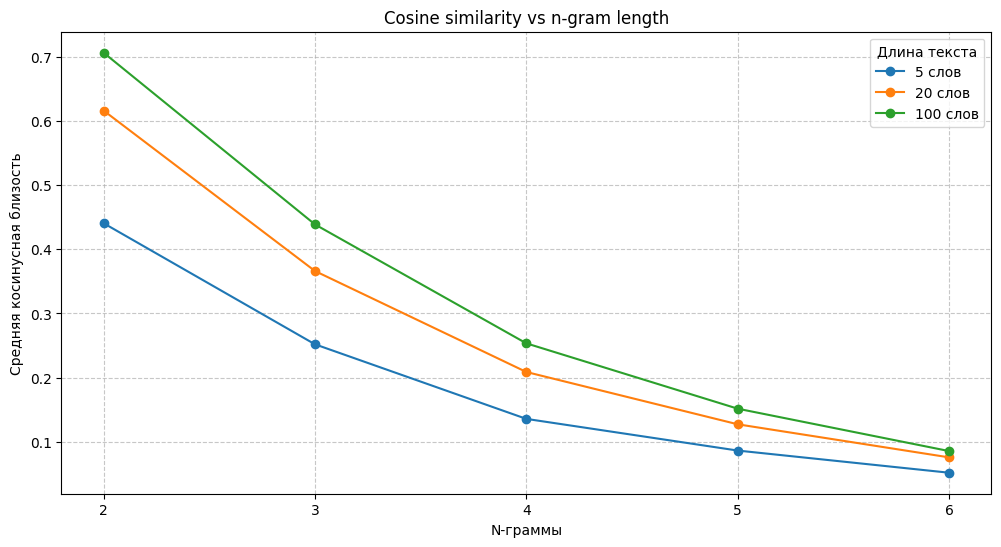

In [ ]:
def plot_cosine_by_length(results):
    n_values = [2, 3, 4, 5, 6]
    lengths  = [5, 20, 100]

    plt.figure(figsize=(12, 6))

    for L in lengths:
        sums = {n: 0.0 for n in n_values}
        cnts = {n: 0   for n in n_values}

        for lang, lang_dict in results["cosine"].items():
            L_dict = lang_dict.get(str(L)) or lang_dict.get(L)
            if not L_dict:
                continue
            for n in n_values:
                if n in L_dict:
                    sums[n] += L_dict[n]
                    cnts[n] += 1

        avg = [sums[n]/cnts[n] if cnts[n] else np.nan for n in n_values]
        plt.plot(n_values, avg, marker='o', label=f'{L} слов')

    plt.xlabel('N-граммы')
    plt.ylabel('Средняя косинусная близость')
    plt.title('Cosine similarity vs n-gram length')
    plt.legend(title='Длина текста')
    plt.grid(alpha=.7, linestyle='--')
    plt.xticks(n_values)
    plt.show()

plot_cosine_by_length(results)

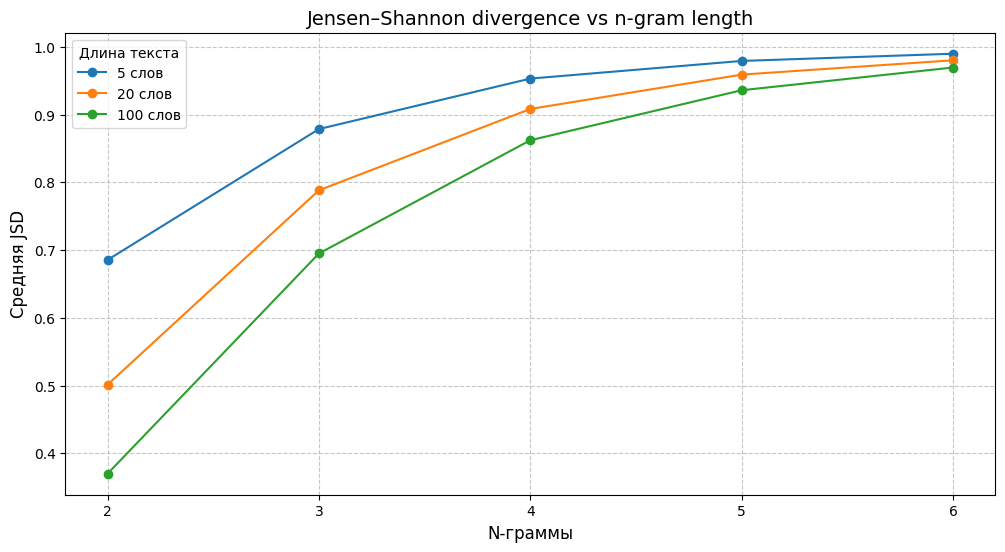

In [ ]:
def plot_jsd_by_length(results):
    n_values = [2, 3, 4, 5, 6]
    lengths  = [5, 20, 100]

    plt.figure(figsize=(12, 6))

    for L in lengths:
        S = {n: 0.0 for n in n_values}
        C = {n: 0   for n in n_values}

        for lang, lang_dict in results["jsd"].items():
            length_dict = lang_dict.get(str(L)) or lang_dict.get(L)
            if length_dict:
                for n in n_values:
                    if n in length_dict:
                        S[n] += length_dict[n]
                        C[n] += 1

        avg = [S[n]/C[n] if C[n] else np.nan for n in n_values]
        plt.plot(n_values, avg, marker='o', label=f'{L} слов')

    plt.xlabel('N-граммы', fontsize=12)
    plt.ylabel('Средняя JSD', fontsize=12)
    plt.title('Jensen–Shannon divergence vs n-gram length', fontsize=14)
    plt.legend(title='Длина текста')
    plt.grid(linestyle='--', alpha=0.7)
    plt.xticks(n_values)
    plt.show()


plot_jsd_by_length(results)

### Реализая ввода текста - получение языка. Поставим метрикой (cos + (1 - jsd)) / 2

In [ ]:
print("Введите текст:")
text = input()
print("Введите N-грамму, по которой собираетесь определять язык:")
n = int(input())
text_cleaned = clean(text)
ngrams = generate_ngrams(text_cleaned,n)
freq = ngrams_frequency_calculate(ngrams)
freq_normalised = normalize_freq(freq)
maxvalue = -1
result_language = ""
for language in corpora_data:
    learned_ngram = corpora_data[language][n]
    cosine = cosine_similarity(learned_ngram, freq_normalised)
    jsd_value = jsd(learned_ngram, freq_normalised)
    if (cosine + (1 - jsd_value)) / 2 > maxvalue:
        maxvalue = (cosine + (1 - jsd_value)) / 2
        result_language = language
print(result_language)